### Dataset for detector

YOLOv8 uses the synthetic images with COCO format labels. Below is to create COCO format labels for YOLOv8

In [10]:
import json
import os

old_label_path = '../dataset/nested2/labels/test'
new_label_path = '../dataset/nested2/yolo_labels/test'

for filename in os.listdir(old_label_path):
    file_path = os.path.join(old_label_path, filename)
    new_file_name = os.path.splitext(filename)[0] + '.txt'
    new_file_path = os.path.join(new_label_path, new_file_name)

    with open(file_path, 'r') as l:
        markers = json.load(l)

    with open(new_file_path, "w") as file:
        for marker in markers:
            img_size = marker['image_size']
            img_height = img_size[0]
            img_width = img_size[1]

            bbox_corners = marker['bbox_corners']
            x1 = bbox_corners[0][0]
            x2 = bbox_corners[2][0]
            y1 = bbox_corners[0][1]
            y2 = bbox_corners[2][1]
            if x1 >= -abs(x1/14) and x2 <= img_width+abs(x1/14) and y2 >= -abs(y1/14) and y2 <= img_height+abs(y2/14):
                x1 = max(0, x1)
                x2 = min(img_width, x2)
                y1 = max(0, y1)
                y2 = min(img_height, y2)
                width = x2 - x1 # horizontal
                height = y2 - y1 # vertical
                center_x = x1 + width/2
                center_y = y1 + height/2
                norm_center_x = center_x / img_width
                norm_center_y = center_y / img_height
                norm_width = width / img_width
                norm_height = height / img_height
                ID = 0
                line = f"{ID} {norm_center_x} {norm_center_y} {norm_width} {norm_height}\n"
                file.write(line)


### Dataset for corner regressor

Create cropped images with 20% margins and labels

In [18]:
import os
import json
import cv2 as cv
import numpy as np
import csv
import sys
project_root = ".."
sys.path.append(project_root)        
from deeparuco.impl.utils import ordered_corners

def write_to_csv(file_path, row_data, write_header=False):
    with open(file_path, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writerow(row_data)

def find_rotation(corners, ordered_c):
    first_corner = np.array(corners[0])
    rotated_90_cw = np.array(ordered_c[3])
    rotated_180 = np.array(ordered_c[2])
    rotated_90_ccw = np.array(ordered_c[1])

    if np.array_equal(first_corner, rotated_90_ccw):
        return 1
    elif np.array_equal(first_corner, rotated_180):
        return 2
    elif np.array_equal(first_corner, rotated_90_cw):
        return 3
    else:
        return 0

fieldnames = ['pic', 'c1_x', 'c1_y', 'c2_x', 'c2_y', 'c3_x', 'c3_y', 'c4_x', 'c4_y']

im_path     = '../dataset/nested2/images/test'
label_path  = '../dataset/nested2/labels/test'
crop_path   = '../dataset/nested2/crops/test'
csv_path    = '../dataset/nested2/crops/test128.csv'

with open(csv_path, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

i = 0
for filename in os.listdir(im_path):
    file_id = os.path.splitext(filename)[0]
    json_filename = file_id + '.json'
    json_file_path = os.path.join(label_path, json_filename)

    with open(json_file_path, 'r') as l:
        data = json.load(l)
    
    im_filename = f"{file_id}.jpg"
    im_file_path = os.path.join(im_path, im_filename)
    im = cv.imread(im_file_path)

    markers = []
    for marker in data:
        id = marker['tag_id']
        crop_filename = f"{file_id}_{id}.jpg"
        crop_file_path = os.path.join(crop_path, crop_filename)
        
        bbox_corners = marker['bbox_corners']
        corners = np.array(marker['corners_inner'])

        top_left = [int(bbox_corners[0][0]),int(bbox_corners[0][1])]
        bottom_right = [int(bbox_corners[2][0]),int(bbox_corners[2][1])]
        xyxy = [
            int(max(top_left[0] - (0.2 * (bottom_right[0] - top_left[0]) + 0.5), 0)),
            int(max(top_left[1] - (0.2 * (bottom_right[1] - top_left[1]) + 0.5), 0)),
            int(min(bottom_right[0] + (0.2 * (bottom_right[0] - top_left[0]) + 0.5), im.shape[1] - 1)),
            int(min(bottom_right[1] + (0.2 * (bottom_right[1] - top_left[1]) + 0.5), im.shape[0] - 1))]

        c1_x = corners[0][0] - xyxy[0]
        c2_x = corners[2][0] - xyxy[0]
        c3_x = corners[3][0] - xyxy[0]
        c4_x = corners[1][0] - xyxy[0]
        c1_y = corners[0][1] - xyxy[1]
        c2_y = corners[2][1] - xyxy[1]
        c3_y = corners[3][1] - xyxy[1]
        c4_y = corners[1][1] - xyxy[1]

        crop = im[xyxy[1]:xyxy[3],xyxy[0]:xyxy[2]]
        orig_h, orig_w = crop.shape[:2]

        resized_crop = cv.resize(im[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]], (128, 128), cv.INTER_NEAREST)
        scale_w = 128 / orig_w
        scale_h = 128 / orig_h

        c1_x = c1_x * scale_w / 128
        c2_x = c2_x * scale_w / 128
        c3_x = c3_x * scale_w / 128
        c4_x = c4_x * scale_w / 128
        c1_y = c1_y * scale_h / 128
        c2_y = c2_y * scale_h / 128
        c3_y = c3_y * scale_h / 128
        c4_y = c4_y * scale_h / 128

        corners = [[c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y]]
        corners_pair = [[c1_x, c1_y], [c2_x, c2_y], [c3_x, c3_y], [c4_x, c4_y]]
        corners_tuple = [[(pred[i], pred[i + 1]) for i in range(0, 8, 2)] for pred in corners]
        ordered_c = [ordered_corners([c[0] for c in cs], [c[1] for c in cs]) for cs in corners_tuple]
        ordered_c = ordered_c[0]
        ordered_c_pair = [[ordered_c[0], ordered_c[1]], [ordered_c[2], ordered_c[3]], [ordered_c[4], ordered_c[5]], [ordered_c[6], ordered_c[7]]]
        rot = find_rotation(corners_pair, ordered_c_pair)
        marker['rot'] = rot
        markers.append(marker)

        row_data = { 'pic': crop_filename,
        'c1_x': ordered_c[0], 'c1_y': ordered_c[1],
        'c2_x': ordered_c[2], 'c2_y': ordered_c[3],
        'c3_x': ordered_c[4], 'c3_y': ordered_c[5],
        'c4_x': ordered_c[6], 'c4_y': ordered_c[7]
        }
        write_to_csv(csv_path, row_data)

        cv.imwrite(crop_file_path, resized_crop)

    with open(json_file_path, 'w') as js:
        json.dump(markers, js, indent=4)

    # i += 1
    # if i > 1000:
    #     break

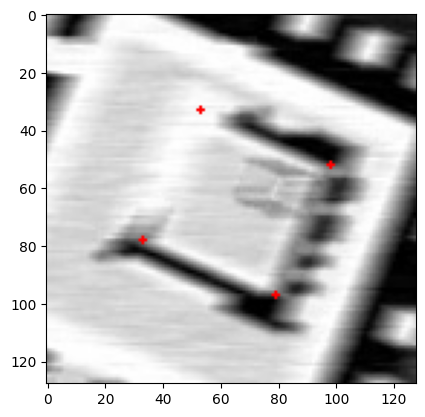

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path   = '../dataset/nested2/crops/val128.csv'
df = pd.read_csv(csv_path)

row = df.iloc[50]

crop_path = '../dataset/nested2/crops/val/' + row.iloc[0]
c1_x = round(float(row.iloc[1]) * 128)
c1_y = round(float(row.iloc[2]) * 128)
c2_x = round(float(row.iloc[3]) * 128)
c2_y = round(float(row.iloc[4]) * 128)
c3_x = round(float(row.iloc[5]) * 128)
c3_y = round(float(row.iloc[6]) * 128)
c4_x = round(float(row.iloc[7]) * 128)
c4_y = round(float(row.iloc[8]) * 128)

corners = [[c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y]]
corners = [[(pred[i], pred[i + 1]) for i in range(0, 8, 2)] for pred in corners]
corners = [ordered_corners([c[0] for c in cs], [c[1] for c in cs]) for cs in corners]
corners = corners[0]
corners = np.array([[corners[0], corners[1]], [corners[2], corners[3]], [corners[4], corners[5]], [corners[6], corners[7]]])

im = cv.imread(crop_path)

for i in range(len(corners)):
        four_corner = tuple(corners[i].astype(int))  # Convert to tuple of ints
        cv.circle(im, four_corner, 1, 255, -1)

plt.imshow(im)
